# Overview for Figures 7 and S11

Imports regionally averaged SST and pCO2 and performs a simple decomposition (thermal / non-thermal) using a modification of the approach in Mongwe et al. (2018).  
The first derivative of the thermal and non-thermal approaches are compared in the figures.  
The difference between the thermal and non-thermal derivatives ($\lambda$) gives whether the GOBM is DIC-dominant and DIC-weak models.  
The average of the STSS and SPSS $\lambda$ gives a sense of the DIC dominance or weakness where > 0 is thermally driven thus DIC-weak. 

### Contributors to the figures and notebook: 

- Luke Gregor (gregorl@ethz.ch)
- Precious Mongwe (pmongwe@csir.co.za)

# Set up notebook and load packages

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import all_my_code as amc

from matplotlib import pyplot as plt

amc.data.set_defaults(resolution=1)

[AMC] version: 0.3.4.dev1+g3ae82d7


# Load data and prepare for decomposition

In [4]:
ds = xr.open_dataset('../data/RECCAP2-SO_monthly-spco2+socat+sst.nc')[['sst', 'spco2']].load()

# find names of pco2 products
product = ds.model.values[ds.data_class.values == 'pco2_prod'].tolist()
gobms = ds.model.values[ds.data_class.values == 'gobm'].tolist()
assim = ds.model.values[ds.data_class.isin(['bsose', 'ecco']).values].tolist()

# use OceanSODA-ETHZ temperature as the official obs temperature
obs_temp = (
    ds.sst
    .sel(model='OceanSODAETHZ', drop=True)
    # create dummy model name
    .expand_dims(model=['pCO2_product'])
    # expand the number of models with dummy model name
    .sel(model=['pCO2_product'] * len(product))
    # rename the model to the real model name (even though it's actually OSETH data)
    .assign_coords(model=product))

# make all product SST a NaN and then fill with the observation temperature we defined above
ds['sst'] = ds.sst.where(~ds.model.isin(product)).fillna(obs_temp)

ds_monthly = (
    ds
    .groupby('time.month').mean('time')
    .sel(month=[12] + list(range(1, 13)) + [1])
    # create new coordinates where 0, 14 are Dec, Jan
    .assign_coords(month=np.arange(0, 14))
    # drop ORCA1 and SOMFFN_Bush. since they don't have SST
    .drop_sel(model=['SOMFFN_Bushinsky'])
)

## Decomposition 

In [4]:
avg = ds_monthly.sel(month=slice(1, 12)).mean('month')

dt = (
    ds_monthly
    # calculates the first derivative along the month dimension
    # since each time step is 1 month, we can simply use diff
    .diff('month', n=1)
    # select the months 1 - 12
    .sel(month=slice(1, 12))
    # there is an offset compared with PM's method, just roll forward 1 month
    .roll(month=1)
)

# calculate pCO2-thermal based on Takahashi 1993
dpCO2_sst = avg.spco2 * 0.0423 * dt.sst
# the residual is the non-thermal component (primarily DIC)
dpCO2_dic = dt.spco2 - dpCO2_sst
# the difference between the two shows the dominant driver
dpCO2_diff = (
    # the absolute value of each driver is taken to see 
    # which one has the largest gradient since they oppose
    (abs(dpCO2_sst) - abs(dpCO2_dic))
    # the remaining lines group by season
    .rename(month='season')
    # the sequence is JFMAMJJASOND corresponding with season as int
    .assign_coords(season=[0,0,0,1,1,1,2,2,2,3,3,3])
    .groupby('season').mean()
    # now assign the month initials to each season
    .assign_coords(season=['DJF', 'MAM', 'JJA', 'SON'])
)
dpCO2_diff = xr.concat([
    dpCO2_diff,
    dpCO2_diff.mean('season').expand_dims(season=['Annual'])
], dim='season')

ds_T_nonT = xr.merge([
    ds_monthly.spco2.sel(month=np.arange(1, 13)).rename('pco2'),
    dpCO2_sst.rename('dpco2_therm'),
    dpCO2_dic.rename('dpco2_nontherm'),
    dpCO2_diff.rename('dpco2_diff')
]).transpose('region', 'model', 'month', 'season').drop_sel(region='SO')

## Assign DIC dominant and weak models

In [5]:
dic_dominant = dpCO2_diff.sel(region=['SPSS', 'STSS'], season='Annual').sum('region') < 0

data_classes = {}
for m in dpCO2_diff.model.values:
    data_class = dpCO2_diff.data_class.sel(model=m).values
    if data_class in ['gobm', 'ecco', 'bsose']:
        strong_weak = 'strong' if dic_dominant.sel(model=m).values else 'weak'
        data_classes[m] = f"model-{strong_weak}"
    elif data_class == 'pco2_prod':
        data_classes[m] = 'product'
        
ds_T_nonT.data_class.values[:] = [data_classes.get(k, 'bad') for k in ds_T_nonT.model.values]

## Prepare data for figures

In [6]:
figure = 'supplementary'

# this is just to make sure that the wrong models don't get into the figures
if figure == "main_text":
    # MPI HAMOCC seasonal cycle amplitude is erroniously large
    drop = ['MPIOM_HAMOCC']
elif figure == "supplementary":
    drop = []
    
# drop the models we don't want in the main text
dsf = ds_T_nonT.load().copy(deep=True).drop_sel(model=drop)

order = ['product', 'model-strong', 'model-weak']
dsf = (dsf
    # for plotting, bar plots start from 0, so we adjust to accommodate
    .assign_coords(month=range(12))
    # get only the data classes that we're interested in 
    .sel(model=dsf.data_class.isin(order)))

ds_avg = dsf.groupby(dsf.data_class).mean().sel(data_class=order)
ds_std = dsf.groupby(dsf.data_class).std().sel(data_class=order)

# we show the GOBM [dic-dominant / dic-weak / avg] 
dpco2_diff = ds_avg.dpco2_diff
# here we calculate GOBM avg
gobm = dsf.data_class.str.startswith('model').values
dpco2_diff_avg = dsf.dpco2_diff.sel(model=gobm).mean('model').expand_dims(data_class=['model-avg'])
# combine the results and then sort accordingly
dpco2_diff = xr.concat([dpco2_diff, dpco2_diff_avg], 'data_class')
dpco2_diff = dpco2_diff.sel(data_class=['product', 'model-avg', 'model-strong', 'model-weak'])

# Plotting main figure

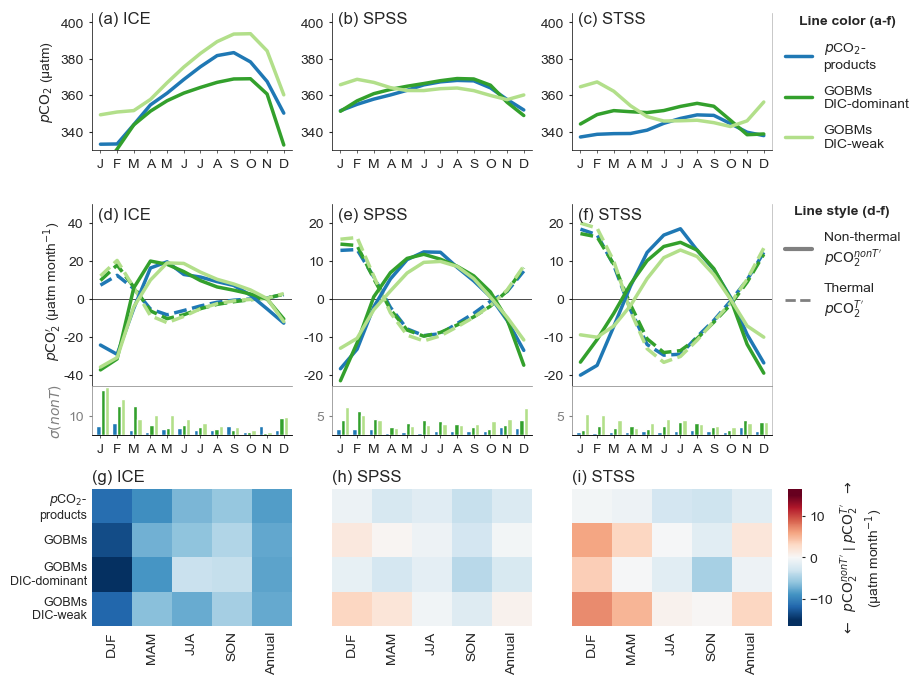

In [7]:
# The `if True:` statements are purely for code folding to make it easier to navigate the notebook 

# in this section, you have to run the data (in the previous cell) as main_text for this cell to work. 
# I exclude MPI compared to the supplementary where it is included.
assert figure == "main_text",  "you have to reload the data in 'main_text' mode so only relevant models are plotted"

# the grey color - #aaaaaa is a lighter option
grey = 'grey'
# the order of the images from left ot right
region = ['ICE', 'SPSS', 'STSS']
# a function to prepare the data for plotting in (a-f)
sel = lambda da, r: da.sel(region=r).to_series().unstack(0)

if True:  # making subplots based on grid shapes
    sns.set_palette('Paired')
    fig = plt.figure(figsize=(8, 7), dpi=100)

    shape = [7, 3]
    axes = [
        plt.subplot2grid(shape, [0, 0], rowspan=2, facecolor='none', fig=fig),
        plt.subplot2grid(shape, [0, 1], rowspan=2, facecolor='none', fig=fig),
        plt.subplot2grid(shape, [0, 2], rowspan=2, facecolor='none', fig=fig),
        plt.subplot2grid(shape, [2, 0], rowspan=3, facecolor='none', fig=fig),
        plt.subplot2grid(shape, [2, 1], rowspan=3, facecolor='none', fig=fig),
        plt.subplot2grid(shape, [2, 2], rowspan=3, facecolor='none', fig=fig),
        plt.subplot2grid(shape, [5, 0], rowspan=2, facecolor='none', fig=fig),
        plt.subplot2grid(shape, [5, 1], rowspan=2, facecolor='none', fig=fig),
        plt.subplot2grid(shape, [5, 2], rowspan=2, facecolor='none', fig=fig)]
    # the bar plots are only added in the section for the bar plots

##################################################
if True:  # first row - pCO2 seasonal cycle
    for ax, r in zip(axes[0:3], region):

        props = dict(color=['C1', 'C3', 'C2'], legend=False, lw=2.5)
        ds_avg.pco2.pipe(sel, r).plot(ax=ax, **props)
        
        ax.set_ylim([330, 405])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
    axes[0].set_ylabel(r'$p\rm{CO}_2$ (µatm)')

##################################################    
if True:  # second row - thermal / non-thermal seas cycle
    
    # the y limits and ticks (ICE is doubled)
    y0, y1 = -36, 25
    yticks = [-20, -10, 0, 10, 20]
    yticklabels = [-20, -10, 0, 10, 20]

    for ax, r in zip(axes[3:6], region):    
        # non-thermal    
        props = dict(color=['C1', 'C3', 'C2'], legend=False, lw=2.5, zorder=2)
        ds_avg.dpco2_nontherm.pipe(sel, r).plot(ax=ax, **props)
        # thermal    
        props.update(ls='--', zorder=1)
        ds_avg.dpco2_therm.pipe(sel, r).plot(ax=ax, **props)
        # 0 line
        ax.axhline(0, lw=0.5, c='k', zorder=0)
        
        # since it's on the left and has 2x ylims, has special config
        if r == 'ICE':
            ax.text(-2.2, 4, r"$p\rm{CO}_2'$ (µatm month$^{{-}1}$)", rotation=90, ha='right', va='center')
            ax.set_ylim(y0*2, y1*2)
            ax.set_yticks([a*2 for a in yticks])
            ax.set_yticklabels([a*2 for a in yticklabels])
            line = ax.axhline(-46, color=grey, lw=0.5)
        else:
            ax.set_ylim(y0, y1)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels)
            line = ax.axhline(-23, color=grey, lw=0.5)
    
##################################################
if True:  # configurations for 1st and 2nd rows (x-axis, titles, spines)
    [a.set_xlabel('') for a in axes[:6]]
    [a.set_xlim(-0.5, 11.5) for a in axes[:6]]
    [a.set_xticks(range(12)) for a in axes[:6]]
    [a.set_xticklabels([m for m in 'JFMAMJJASOND']) for a in axes[:6]]

    props = dict(x=0.03, y=0.95, ha='left', va='top')
    axes[0].set_title('(a) ICE',  **props)
    axes[1].set_title('(b) SPSS', **props)
    axes[2].set_title('(c) STSS', **props)
    axes[3].set_title('(d) ICE',  **props)
    axes[4].set_title('(e) SPSS', **props)
    axes[5].set_title('(f) STSS', **props)
        
    for right in [2, 5]:
        ax = axes[right]
        spine = ax.spines['right']
        spine.set_color(grey)
        spine.set_visible(True)
        spine.set_alpha(0.6)

##################################################
if True:  # third row - sum of first derivative (DIC-dominant or DIC-weak)
    for ax, r in zip(axes[6:9], region):
        # we use the heatmap functoin since it does all the labelling automatically
        df = dpco2_diff.pipe(sel, r).T
        sns.heatmap(df, ax=ax, cmap='RdBu_r', vmin=-15, vmax=15, cbar=False)
        
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.tick_params('y', length=0, labelsize=9)
        ax.tick_params('x', length=0, rotation=90)
        if r != 'ICE':
            ax.set_yticklabels([])
            ax.set_yticks([])

    axes[6].set_yticklabels([
        '$p$CO$_2$-\nproducts',
        'GOBMs',
        'GOBMs\nDIC-dominant',
        'GOBMs\nDIC-weak'])
    
    # could put this in a loop, but keep it simple with letters
    axes[6].set_title('(g) ICE', x=0.0, ha='left')
    axes[7].set_title('(h) SPSS', x=0.0, ha='left')
    axes[8].set_title('(i) STSS', x=0.0, ha='left')

    fig.subplots_adjust(right=0.9, hspace=1.3, wspace=0.2)

    # create the colorbar axes manually 
    p5 = axes[8].get_position()
    cax = fig.add_axes([p5.x1 + 0.02, p5.y0, 0.017, p5.height])
    cb = plt.colorbar(axes[8].get_children()[0], cax=cax, extend='both', extendfrac=0.05, extendrect=True)
    cb.outline.set_lw(0)
    cb.ax.tick_params(length=2)
    # lavel shows blue is DIC-dominant, red is DIC-weak (or thermally driven)
    cb.set_label("$\leftarrow$  $p\mathrm{CO}_2^{nonT'}$ | $p\mathrm{CO}_2^{T'}$  $\\rightarrow$\n(µatm month$^{-1}$)")
    
##################################################   
if True:  # stdev bars (in second row)
    # the bars showing the standard deviation of the non-thermal component in d-f
    props = dict(color=['C1', 'C3', 'C2'], legend=False, lw=2.5, zorder=2)

    # the strategy is to create axes inside d-f based on the limits of the existing plots
    for ax, r in zip(axes[3:6], region):
        # nonthermal stdev
        ylim0 = ax.get_ylim()[0]
        ylim1 = ax.get_lines()[-1].get_data()[1][1]
        # create the axes
        ta = ax.inset_axes([-0.5, ylim0, 12, abs(ylim1 - ylim0)], transform=ax.transData)
        
        # plotting with pandas since it plots all three bars together
        df = ds_std.dpco2_nontherm.pipe(sel, r)
        df.plot.bar(ax=ta, color=props['color'], legend=False, width=0.8)
        
        ta.set_xlabel('')
        ta.set_xticks([])
        # setting the spines to be grey so that they are visually separate from the rest
        ta.spines['top'].set_visible(True)
        [ta.spines[s].set_color(grey) for s in ta.spines]
        ta.spines['bottom'].set_color('k')
        
        if r == 'ICE':
            ta.set_ylabel('$\sigma(nonT)$', color=grey)
            ta.set_yticks([10])
            ta.set_ylim(0, 25)
        else:
            ta.set_ylabel('')
            ta.set_yticks([5])
            ta.set_ylim(0, 12.5)
        
        ta.tick_params(colors=grey)

##################################################  
if True:  # legend
    # for the colors, we get the info from the first plot
    ax = axes[0]
    lines_colors = [l for l in ax.get_lines() if not l.get_label().startswith('_')]
    labels_colors = ['$p$CO$_2$-\nproducts', 'GOBMs\nDIC-dominant', 'GOBMs\nDIC-weak']
    
    lines_styles = [
        ax.plot(0, 0, color=grey, lw=2, zorder=1, ls='--', label="Non-thermal\n$p\mathrm{CO}_2^{nonT'}$")[0],
        ax.plot(0, 0, color=grey, lw=3, zorder=2, ls='-', label="Thermal\n$p\mathrm{CO}_2^{T'}$")[0]]
    labels_styles = [l.get_label() for l in lines_styles]

    props = dict(ncol=1, loc='upper left', labelspacing=1, frameon=True, edgecolor='none')
    lgnd1 = axes[2].legend(lines_colors, labels_colors, title='Line color (a-f)', bbox_to_anchor=[1, 1.08], **props)
    lgnd2 = axes[5].legend(lines_styles, labels_styles, title='Line style (d-f)', bbox_to_anchor=[1, 1.05], **props)
    
    for lgnd in [lgnd1, lgnd2]:
        title = lgnd.get_title()
        title.set_horizontalalignment('left')
        title.set_fontweight('bold')

fig.savefig('./fig07_driver_seas_cycle_decomp.pdf', bbox_inches='tight')

# Supplementary

In [9]:
assert figure == "supplementary", "you have to reload the data in 'supplementary' mode so all models are present"


da = dsf.dpco2_diff.sel(model=dsf.sortby(['data_class', 'model']).model.values)
y = da.data_class.to_series().value_counts().sort_index().cumsum().values

nice_cols = [
    'CESM-ETHZ', 'NorESM-OC1.2 ', 'ORCA025-GEOMAR', 'CCSM-WHOI', 'ROMS-SouthernOcean-ETHZ', 
    'CNRM-ESM2-1 ', 'EC-Earth3', 'FESOM-REcoM-HR', 'FESOM-REcoM-LR', 'MOM6-Princeton', 
    'MRI-ESM2-1 ', 'NEMO-PlankTOM12.1', 'B-SOSE', 'ECCO-Darwin', 'AOML-EXTRAT', 'CMEMS-LSCE-FFNN', 
    'CSIR-ML6', 'JMA-MLR', 'Jena-CarboScope', 'NIES-ML3', 'OceanSODA-ETHZ', 'MPI-SOMFFN', 
    'Watson2020', 'LDEO-HPD', 'MPIOM-HAMMOC', 'ORCA1-LIM3-PISCES']

from all_my_code.munging import name_matching
yticklabels = []
for old_name in da.model.values:
    matches = name_matching.fuzzy_matching(old_name, nice_cols).mean(axis=1)
    yticklabels += matches.idxmax(),

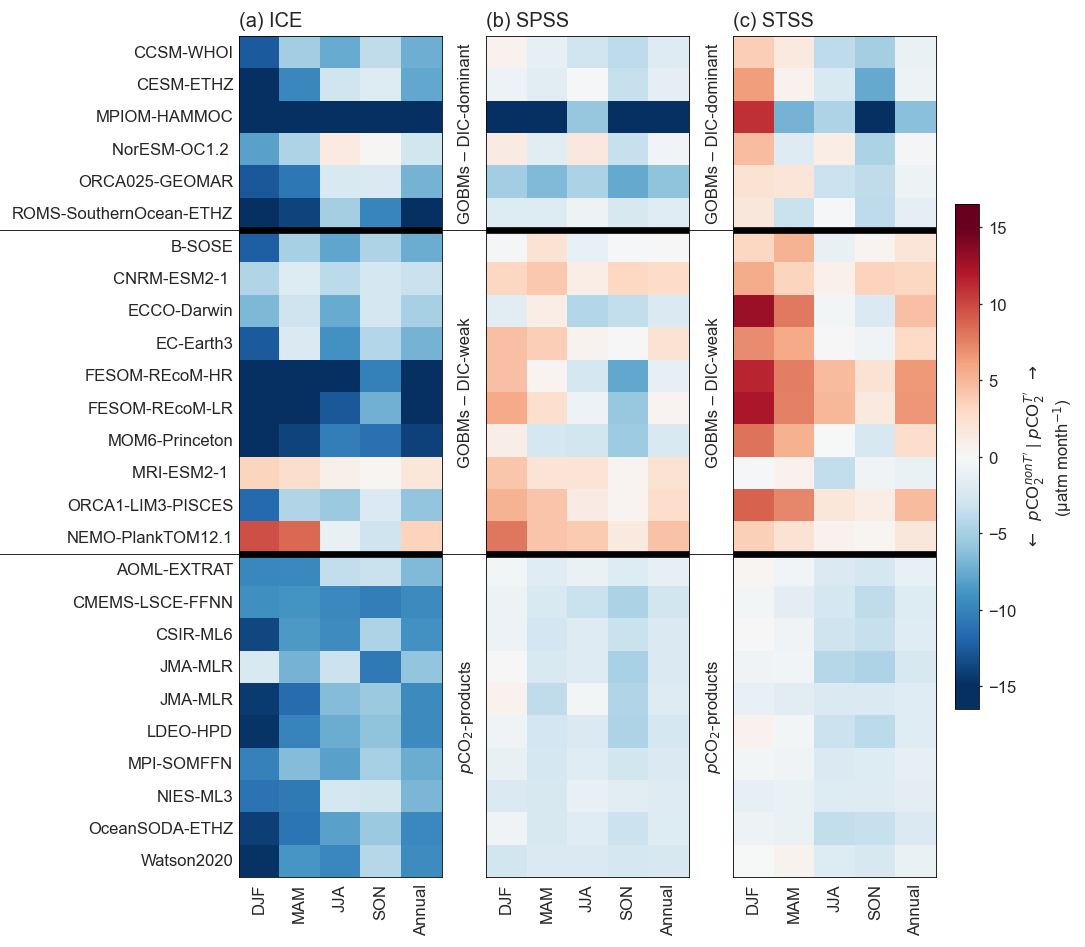

In [12]:
fig, axes = plt.subplots(1, 3, figsize=[8, 8], sharey=True)

for ax, region, letter in zip(axes, ['ICE', 'SPSS', 'STSS'], 'abc'):
    df = da.sel(region=region).to_series().unstack(1)
    
    img = sns.heatmap(df, cmap='RdBu_r', vmin=-15, vmax=15, ax=ax, cbar=False)
    ax.hlines(y[:-1], *ax.get_xlim(), color='k', lw=4)
    
    ax.set_title(f"({letter}) {region}", x=0, ha='left')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    ax.tick_params(length=0)
    ax.tick_params(axis='x', rotation=90)
    
    [ax.spines[s].set_visible(True) for s in ax.spines]
axes[0].set_yticklabels(yticklabels)

for ax in axes[:-1]:
    props = dict(rotation=90, size='medium', ha='center', va='center')
    ax.text(5.6, y[0] / 2, 'GOBMs – DIC-dominant', **props)
    ax.text(5.6, y[0] + (y[1] - y[0]) / 2, 'GOBMs – DIC-weak', **props)
    ax.text(5.6, y[1] + (y[2] - y[1]) / 2, '$p$CO$_2$-products', **props)

plt.tight_layout(w_pad=0.1)

p = axes[-1].get_position()
cax = fig.add_axes([p.x1 + 0.02, p.y0 + p.height * 0.2, 0.025, p.height * 0.6])

cb = plt.colorbar(img.get_children()[0], cax=cax, extend='both', extendfrac=0.05, extendrect=True)
cb.outline.set_lw(0.5)
cb.ax.tick_params(length=2)

cb.set_label("$\leftarrow$  $p\mathrm{CO}_2^{nonT'}$ | $p\mathrm{CO}_2^{T'}$  $\\rightarrow$\n(µatm month$^{-1}$)")

axes[1].hlines(y[:-1], -20, 10, color='k', lw=0.5, clip_on=False)

fig.savefig('./figS11_driver_seas_cycle_decomp.pdf', bbox_inches='tight')